In [1]:
# importing packages
import numpy as np
import pandas as pd
import sqlite3
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# importing zipped csv data
gross = pd.read_csv('Data/bom.movie_gross.csv.gz', compression = 'gzip')
info = pd.read_csv('Data/rt.movie_info.tsv.gz', compression = 'gzip', sep='\t')
reviews = pd.read_csv('Data/rt.reviews.tsv.gz', compression = 'gzip', sep='\t', encoding='unicode-escape')
tmdb = pd.read_csv('Data/tmdb.movies.csv.gz', compression = 'gzip')
budgets = pd.read_csv('Data/tn.movie_budgets.csv.gz', compression = 'gzip')

In [50]:
# importing database file
conn = sqlite3.connect('Data/im.db')
persons = pd.read_sql("""SELECT * FROM persons""", conn)
principals = pd.read_sql("""SELECT * FROM principals""", conn)
known_for = pd.read_sql("""SELECT * FROM known_for""", conn)
directors = pd.read_sql("""SELECT * FROM directors""", conn)
writers = known_for = pd.read_sql("""SELECT * FROM writers""", conn)
movie_basics = pd.read_sql("""SELECT * FROM movie_basics""", conn)
movie_ratings = pd.read_sql("""SELECT * FROM movie_ratings""", conn)
movie_akas = pd.read_sql("""SELECT * FROM movie_akas""", conn)

## 2. Cleaning

#### Gross

In [5]:
gross.dtypes

title              object
studio             object
domestic_gross    float64
foreign_gross      object
year                int64
dtype: object

In [6]:
gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [7]:
# making foreign gross a float
gross['foreign_gross'] = gross['foreign_gross'].replace('[,]', '', regex=True).astype('float64')
gross['foreign_gross'].fillna(0, inplace=True)

#### Info

In [8]:
info.dtypes

id               int64
synopsis        object
rating          object
genre           object
director        object
writer          object
theater_date    object
dvd_date        object
currency        object
box_office      object
runtime         object
studio          object
dtype: object

In [9]:
info.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


In [11]:
# making dates datetime
info['theater_date'] = pd.to_datetime(info['theater_date'])
info['dvd_date'] = pd.to_datetime(info['dvd_date'])
# dropping currency, it is not needed
info.drop('currency',axis=1,inplace=True)

# making box_office a float
info['box_office'] = info['box_office'].str.replace(',', '')
info['box_office'] = info['box_office'].astype('float64')

# making runtaime a flaot
info['runtime'] = info['runtime'].str.split(' ').str[0]
info['runtime'] = info['runtime'].astype('float64')

#### Reviews

In [12]:
reviews.dtypes

id             int64
review        object
rating        object
fresh         object
critic        object
top_critic     int64
publisher     object
date          object
dtype: object

In [13]:
reviews.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


In [14]:
# changing fresh_rotten into a boolean
reviews['fresh'].replace('fresh', 1, inplace=True)
reviews['fresh'].replace('rotten', 0, inplace=True)
reviews['fresh'] = reviews['fresh'].astype(bool)
reviews['fresh'].value_counts()

True     33035
False    21397
Name: fresh, dtype: int64

In [15]:
# making the date datetime
reviews['date'] = pd.to_datetime(reviews['date'])

In [17]:
# cleaning reviews with '/' and '.', pt. 1
# to do: make a function
reviews.loc[reviews['rating'].str.contains('/5')==True, ['rating_out_of_5']] = True
reviews.loc[reviews['rating'].str.contains('/5')==True, ['rating']] = reviews['rating'].str.split('/').str[0]
reviews.loc[reviews['rating'].str.contains('/6')==True, ['rating_out_of_6']] = True
reviews.loc[reviews['rating'].str.contains('/6')==True, ['rating']] = reviews['rating'].str.split('/').str[0]
reviews.loc[reviews['rating'].str.contains('/4')==True, ['rating_out_of_4']] = True
reviews.loc[reviews['rating'].str.contains('/4')==True, ['rating']] = reviews['rating'].str.split('/').str[0]
reviews.loc[reviews['rating'].str.contains('/10')==True, ['rating_out_of_10']] = True
reviews.loc[reviews['rating'].str.contains('/10')==True, ['rating']] = reviews['rating'].str.split('/').str[0]
reviews.loc[reviews['rating'].str.contains('.')==True, ['rating_out_of_10']] = True

In [18]:
# manually replacing odd values
# todo: make a dictionary
reviews['rating'].replace('A+', 1, inplace=True)
reviews['rating'].replace('A', 1, inplace=True)
reviews['rating'].replace('A-', .95, inplace=True)
reviews['rating'].replace('B+', .85, inplace=True)
#
reviews['rating'].replace('B', .8, inplace=True)
reviews['rating'].replace('B-', .75, inplace=True)
reviews['rating'].replace('C+', .65, inplace=True)
reviews['rating'].replace('C', .6, inplace=True)
reviews['rating'].replace('C-', .55, inplace=True)
reviews['rating'].replace('D+', .45, inplace=True)
reviews['rating'].replace('D', .4, inplace=True)
reviews['rating'].replace('D-', .35, inplace=True)
reviews['rating'].replace('F+', .25, inplace=True)
reviews['rating'].replace('F', .2, inplace=True)
reviews['rating'].replace('F-', .15, inplace=True)
reviews['rating'].replace(['2.1/2','R','N','T','1-5','3/2'], 'NaN', inplace=True)
reviews['rating'].replace('3 1/2', .7, inplace=True)
reviews['rating'].replace('6/8', .75, inplace=True)
reviews['rating'].replace('2/2', 1, inplace=True)
reviews['rating'].replace('1/2', .5, inplace=True)

In [19]:
# cleaning reviews with '/' and '.', pt. 2
reviews.loc[reviews['rating_out_of_4']==True, ['rating']] = reviews['rating'].astype('float64') / 4
reviews.loc[reviews['rating_out_of_5']==True, ['rating']] = reviews['rating'].astype('float64') / 5
reviews.loc[reviews['rating_out_of_6']==True, ['rating']] = reviews['rating'].astype('float64') / 6
reviews.loc[reviews['rating_out_of_10']==True, ['rating']] = reviews['rating'].astype('float64') / 10
reviews.drop(['rating_out_of_4','rating_out_of_5','rating_out_of_6','rating_out_of_10'],axis=1,inplace=True)

In [20]:
# making rating a float
reviews['rating'] = reviews['rating'].astype('float64')

0           3
1           3
2           3
3           3
4           3
         ... 
54427    2000
54428    2000
54429    2000
54430    2000
54431    2000
Name: id, Length: 54432, dtype: int64

#### tmdb

In [23]:
tmdb.dtypes

Unnamed: 0             int64
genre_ids             object
id                     int64
original_language     object
original_title        object
popularity           float64
release_date          object
title                 object
vote_average         float64
vote_count             int64
dtype: object

In [24]:
tmdb.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [25]:
# getting rid of unnecessary column
tmdb.drop('Unnamed: 0', axis=1, inplace=True)

In [26]:
# making release date datetime
tmdb['release_date'] = pd.to_datetime(tmdb['release_date'])

In [149]:
#same units for rating 
tmdb['vote_average'] = tmdb['vote_average']/10
tmdb['vote_average']

0        0.77
1        0.77
2        0.68
3        0.79
4        0.83
         ... 
26512    0.00
26513    0.00
26514    0.00
26515    0.00
26516    0.00
Name: vote_average, Length: 26517, dtype: float64

#### Budgets

In [35]:
budgets.dtypes

id                            int64
release_date         datetime64[ns]
movie                        object
production_budget             int32
domestic_gross                int32
worldwide_gross               int64
dtype: object

In [36]:
budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,425000000,760507625,2776345279
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747


In [37]:
# making release_date datetime
budgets['release_date'] = pd.to_datetime(budgets['release_date'])

In [38]:
# removing '$' and ',' from money variables
budgets['production_budget'] = budgets['production_budget'].replace('[$,]', '', regex=True).astype(int)
budgets['domestic_gross'] = budgets['domestic_gross'].replace('[$,]', '', regex=True).astype(int)
budgets['worldwide_gross'] = budgets['worldwide_gross'].replace('[$,]', '', regex=True).astype('int64')

In [46]:
budgets

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,425000000,760507625,2776345279
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747
...,...,...,...,...,...,...
5777,78,2018-12-31,Red 11,7000,0,0
5778,79,1999-04-02,Following,6000,48482,240495
5779,80,2005-07-13,Return to the Land of Wonders,5000,1338,1338
5780,81,2015-09-29,A Plague So Pleasant,1400,0,0


#### Movie Basics

In [51]:
movie_basics.dtypes

movie_id            object
primary_title       object
original_title      object
start_year           int64
runtime_minutes    float64
genres              object
dtype: object

In [52]:
movie_basics.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [53]:
#making the id an int
movie_basics['movie_id'] = movie_basics['movie_id'].str.split('tt').str[1]
movie_basics['movie_id'] = movie_basics['movie_id'].astype(int)

#### Movie Ratings

In [54]:
movie_ratings.dtypes

movie_id          object
averagerating    float64
numvotes           int64
dtype: object

In [55]:
movie_ratings.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [56]:
#making the id an int
movie_ratings['movie_id'] = movie_ratings['movie_id'].str.split('tt').str[1]
movie_ratings['movie_id'] = movie_ratings['movie_id'].astype(int)

# Cleaning 2: matching values

In [81]:
info_genres = []
nan_val = 0
for gl in list(info.genre.str.split('|')):
        if type(gl) != type([]):
            nan_val += 1
        else:
            for gen in gl:
                info_genres.append(gen)
            
            
list(set(info_genres))  

['Art House and International',
 'Romance',
 'Comedy',
 'Special Interest',
 'Sports and Fitness',
 'Television',
 'Mystery and Suspense',
 'Drama',
 'Horror',
 'Action and Adventure',
 'Documentary',
 'Faith and Spirituality',
 'Anime and Manga',
 'Kids and Family',
 'Classics',
 'Animation',
 'Gay and Lesbian',
 'Cult Movies',
 'Science Fiction and Fantasy',
 'Musical and Performing Arts',
 'Western']

In [87]:
im_genres = []
nan_val = 0
for gl in list(movie_basics.genres.str.split(',')):
        if type(gl) != type([]):
            nan_val += 1
        else:
            for gen in gl:
                im_genres.append(gen)
            
            
list(set(im_genres))  

['Reality-TV',
 'Romance',
 'Comedy',
 'Music',
 'Adult',
 'Game-Show',
 'Mystery',
 'Fantasy',
 'Family',
 'Crime',
 'Sport',
 'Short',
 'Action',
 'Drama',
 'Horror',
 'Sci-Fi',
 'Talk-Show',
 'Musical',
 'Documentary',
 'Adventure',
 'War',
 'News',
 'Animation',
 'Thriller',
 'Western',
 'History',
 'Biography']

In [183]:
genres = list(set(im_genres + info_genres))

In [100]:
genres_dict = {
    'Reality-TV':'TV Show',
    'Art House and International':'Art',
    'Romance':'Romance',
    'Comedy':'Comedy',
    'Music':'Music',
    'Special Interest':'Special Interest',
    'Adult':'Adult',
    'Game-Show':'TV Show',
    'Mystery':'Mystery and Suspense',
    'Fantasy':'Science Fiction and Fantasy',
    'Family':'Kids and Family',
    'Crime':'Mystery and Suspense',
    'Sport':'Sports and Fitness',
    'Short':'Shorts',
    'Television':'TV Show',
    'Sports and Fitness':'Sports and Fitness',
    'Mystery and Suspense':'Mystery and Suspense',
    'Action':'Action and Adventure',
    'Drama':'Drama',
    'Horror':'Horror',
    'Sci-Fi':'Science Fiction and Fantasy',
    'Talk-Show':'TV Show',
    'Action and Adventure':'Action and Adventure',
    'Musical':'Music',
    'Documentary':'Documentary',
    'Adventure':'Action and Adventure',
    'Faith and Spirituality':'Faith and Spirituality',
    'Anime and Manga':'Animation',
    'Kids and Family':'Kids and Family',
    'War':'Action and Adventure',
    'News':'TV Show',
    'Classics':'Classic',
    'Animation':'Animation',
    'Thriller':'Mystery and Suspense',
    'Gay and Lesbian':'LGBTQ+',
    'Cult Movies':'Classic',
    'Science Fiction and Fantasy':'Science Fiction and Fantasy',
    'Musical and Performing Arts':'Music',
    'Western':'Western',
    'History':'History',
    'Biography':'Biography',
    28:'Action and Adventure',
    12:'Action and Adventure',
    16:'Animation',
    35:'Comedy',
    80:'Mystery and Suspense',
    99:'Documentary',
    18:'Drama',
    10751:'Kids and Family',
    14:'Science Fiction and Fantasy',
    36:'History',
    27:'Horror',
    10402:'Music',
    9648 :'Mystery',
    10749:'Romance',
    878:'Science Fiction and Fantasy',
    10770:'TV Show',
    53:'Mystery and Suspense',
    10752:'Action and Adventure',
    37:'Western'
    }

In [180]:
info_genres_df = info[['id','genre']] 
info_genres_df = info_genres_df.set_index('id').apply(lambda x: x.str.split('|').explode()).reset_index()
info_genres_df['genre'] = info_genres_df['genre'].map(genres_dict)

info_genres_df.drop_duplicates(inplace = True)

In [181]:
info_genres_ratings = pd.merge(info_genres_df, reviews[['id','rating']].groupby('id').mean(), 
         left_on='id',          # column for df_flights
         right_on='id',      # column for df_airports
         how='left')

In [182]:
info_genres_ratings

,id,genre,rating
0,1,Action and Adventure,NaN
1,1,Classic,NaN
2,1,Drama,NaN
3,3,Drama,0.130243
4,3,Science Fiction and Fantasy,0.130243
...,...,...,...
3575,2000,Action and Adventure,0.056417
3576,2000,Art,0.056417
3577,2000,Comedy,0.056417
3578,2000,Drama,0.056417


A movie can belong to many genres. Each roy correspons to a pair movie_id,genre.
An avg rating for each movie was calculated and attached via a left join.

Note: The info table has no movie name 

In [188]:
import ast
tmdb_genre_ratings_df  = tmdb[['id','original_title','genre_ids','vote_average']]
tmdb_genre_ratings_df = tmdb_genre_ratings_df.set_index(['id','original_title','vote_average'])
tmdb_genre_ratings_df = tmdb_genre_ratings_df['genre_ids'].map(lambda x: ast.literal_eval(x)).explode().to_frame().reset_index()
tmdb_genre_ratings_df['genre_ids'] = tmdb_genre_ratings_df['genre_ids'].map(genres_dict)
tmdb_genre_ratings_df.drop_duplicates(inplace = True)
tmdb_genre_ratings_df.rename(columns = {'genre_ids':'genre', 'vote_average':'rating'}, inplace = True)

tmdb_genre_ratings_df

,id,original_title,rating,genre
0,12444,Harry Potter and the Deathly Hallows: Part 1,0.77,Action and Adventure
1,12444,Harry Potter and the Deathly Hallows: Part 1,0.77,Science Fiction and Fantasy
2,12444,Harry Potter and the Deathly Hallows: Part 1,0.77,Kids and Family
3,10191,How to Train Your Dragon,0.77,Science Fiction and Fantasy
4,10191,How to Train Your Dragon,0.77,Action and Adventure
...,...,...,...,...
47827,381231,The Last One,0.00,Action and Adventure
47829,366854,Trailer Made,0.00,Kids and Family
47830,366854,Trailer Made,0.00,Action and Adventure
47832,309885,The Church,0.00,Mystery and Suspense


In [195]:
movie_basics_genres_df = movie_basics[['movie_id','genres']] 
movie_basics_genres_df = movie_basics_genres_df.set_index('movie_id').apply(lambda x: x.str.split('|').explode()).reset_index()
movie_basics_genres_df['genres'] = movie_basics_genres_df['genres'].map(genres_dict)

movie_basics_genres_df.drop_duplicates(inplace = True)

In [199]:
movie_ratings['averagerating']/10

0        0.83
1        0.89
2        0.64
3        0.42
4        0.65
         ... 
73851    0.81
73852    0.75
73853    0.47
73854    0.70
73855    0.63
Name: averagerating, Length: 73856, dtype: float64

In [200]:
movie_basics_genres_ratings_df = pd.merge(movie_basics_genres_df,movie_ratings.set_index('movie_id')['averagerating']/10,on = 'movie_id',how = 'left')
movie_basics_genres_ratings_df

,movie_id,genres,averagerating
0,63540,NaN,0.70
1,66787,NaN,0.72
2,69049,Drama,0.69
3,69204,NaN,0.61
4,100275,NaN,0.65
...,...,...,...
146139,9916538,Drama,NaN
146140,9916622,Documentary,NaN
146141,9916706,Comedy,NaN
146142,9916730,NaN,NaN


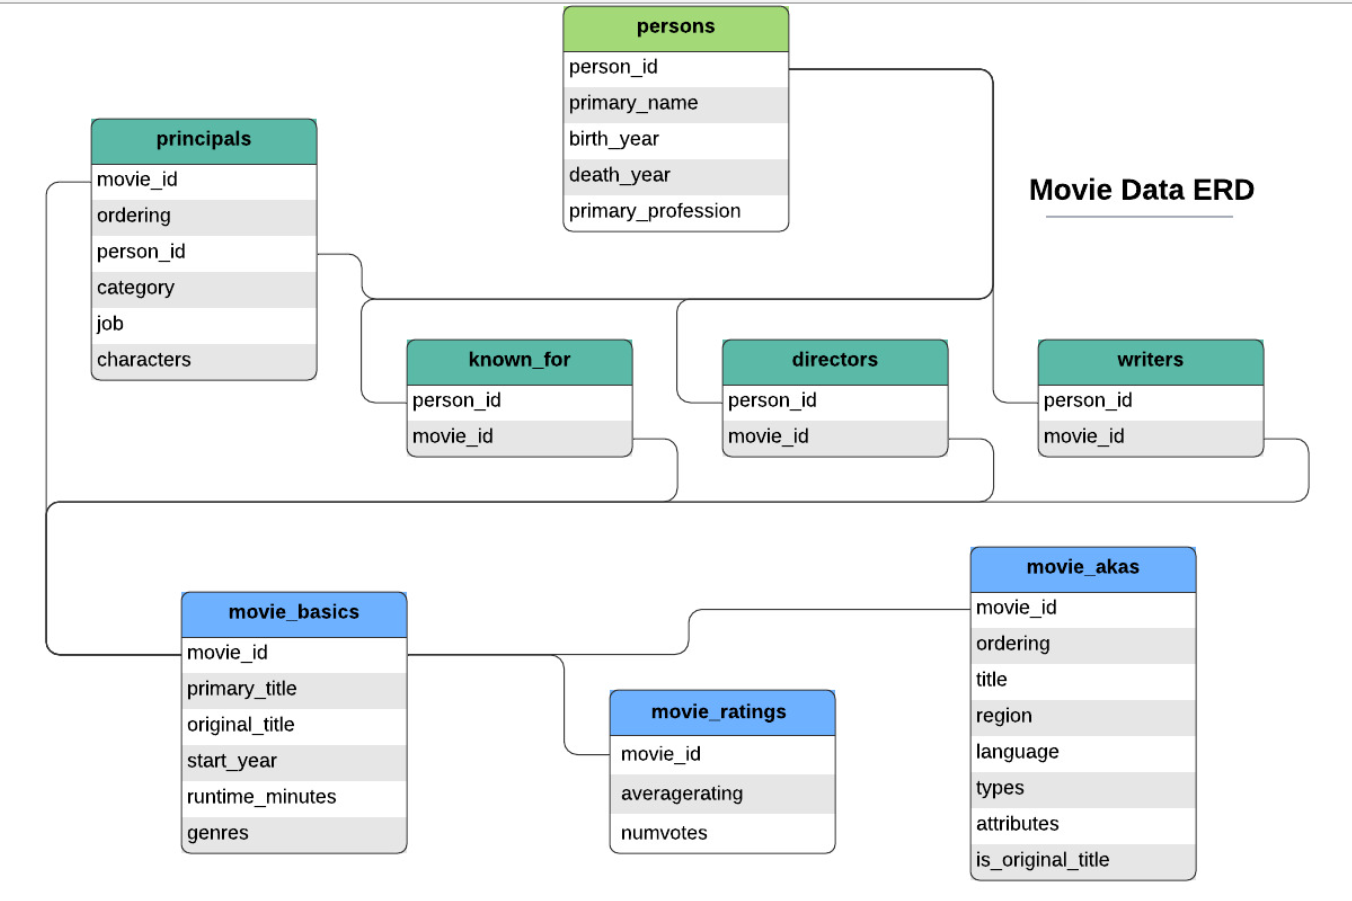